# Self-Driving Car Engineer Nanodegree


## Project 5: **Vehicle Detection and Tracking ** 


In the Vehicle Detection and Tracking project we have to recognize other vehicles in the field of view of the camera and track the vehicle position over multiple frames.   

Steps that have to be performed: 
- Load training and test data 
- Create a SVC using sklearn 
- Find optimal parameters for SVC training (e.g. C and gamma) 
- Implement a pipeline for vehicle detection and tracking 
-- Generate search windows 
-- Classify search windows 
-- Perform outlier rejection 
-- Visualize detected vehicles (e.g. bounding boxes around estimated vehicle posisiton)


### Library import and helper functions 

In the follwing section code of the udacity project course section is reused. Steps performed: 
- Loaded training and test images 
- Randomized search of optimal parameters 
- Training resut is saved to a pickle file 

I used the RandomizedSearchCV to find the optimal parameters for my SVC. With this approach several configurations of C and gamma where ran automatized and the best results was saved to disk.  The classification score on the test image set looks promising. 

I used the HOG features of three channels of the LUV color space to train the SVC. With following parameters: 
- orient = 8
- pix_per_cell = 8
- cell_per_block = 2

Which proved to be a good choise empirically. 

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
#from sklearn.svm import LinearSVC
import pickle
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy import stats

from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

%matplotlib inline

# Code from example 
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# Code from udacity course section
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True, transform_SQRT=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=transform_SQRT, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=transform_SQRT, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
def convert_color(img, cspace='RGB'):
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)     
    return feature_image
    
    
# Code from udacity course section
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
  
        feature_image = convert_color(image, cspace='YUV')
           
        # When NAN values appear at normalization step --> transform_sqrt=False 
        # transform_SQRT=False
            
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True, transform_SQRT=False))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True, transform_SQRT=False)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features




### TODO: Tweak these parameters and see how the results change.
colorspace = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" #"ALL" # Can be 0, 1, 2, or "ALL"


# Set to false if you want to retrain 
load_svm = True
load_images = False 

if load_images == True: 

    # Loading cars and not cars images from disk 
    cars = glob.glob('./vehicles/*/*.png')
    notcars = glob.glob('./non-vehicles/*/*.png')

    print('Number of car samples: ', len(cars))
    print('Number of not car samples: ', len(cars))
 
    sample_size = len(cars)
    cars = cars[0:sample_size]
    notcars = notcars[0:sample_size]

    t=time.time()

    # Extracting CAR HOG Features 
    car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)

    # Extracting NOT CAR HOG Features 
    notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)

    ############### Normalizing Features 
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract HOG features...')


    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

    # Fit a per-column scaler
    #X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    #scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=rand_state)
    #X_train, X_test, y_train, y_test = train_test_split(
    #    scaled_X, y, test_size=0.2, random_state=rand_state)

if load_svm == False: 
    
    ################ Training SVC
    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
  
    svc = svm.SVC()
    
    # Parameter search range definitions 
    param_dist = {'C': stats.expon(scale=100), 'gamma': stats.expon(scale=.1),
      'kernel': ['linear','rbf'], 'class_weight':['balanced', None]}

    # Running 20 iterations of randomized search to find optimal parameters 
    n_iter_search = 20
    random_search = RandomizedSearchCV(svc, param_distributions=param_dist, n_iter=n_iter_search, n_jobs= 3)
    start = time.time()
    random_search.fit(X_train, y_train)

    # Printing results of training 
    print("RandomizedSearchCV took %.2f seconds for %d candidates"
          " parameter settings." % ((time.time() - start), n_iter_search))
    report(random_search.cv_results_)
    
    # Saving result to disk, because training takes quite long 
    print("Saving SVC training results")
    f = open('random_search_svc_result_2.pkl', 'wb')
    pickle.dump(random_search, f)
    f.close()
    print("Saving completed")
    
    scv_classyfier = random_search
else:
    # Loading calibration
    print("Loading SVC training results")
    f = open('random_search_svc_result_full_training_LUV.pkl', 'rb')
    scv_classyfier = pickle.load(f)
    f.close()
    print("Loading complete")



# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy





Loading SVC training results
Loading complete


## Result of a full RandomizedSearchCV training 

The follwing shows the report summary of the RandomizedSearch. 

Number of car samples:  8792
Number of not car samples:  8792

/home/vuk/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)

120.64 Seconds to extract HOG features...
Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 4704
RandomizedSearchCV took 5152.68 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.993 (std: 0.000)
Parameters: {'gamma': 0.10925496029625786, 'C': 244.26224860807565, 'kernel': 'rbf', 'class_weight': None}

Model with rank: 2
Mean validation score: 0.992 (std: 0.000)
Parameters: {'gamma': 0.086233036977514402, 'C': 18.330163692478781, 'kernel': 'rbf', 'class_weight': None}

Model with rank: 3
Mean validation score: 0.992 (std: 0.000)
Parameters: {'gamma': 0.18298554132477579, 'C': 358.03390387123073, 'kernel': 'rbf', 'class_weight': None}

Model with rank: 3
Mean validation score: 0.992 (std: 0.000)
Parameters: {'gamma': 0.074905334855268846, 'C': 282.82476231987499, 'kernel': 'rbf', 'class_weight': None}

Saving SVC training results
Saving completed


In [2]:
if load_images == True: 
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(scv_classyfier.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print(X_test[0])
    print(len(X_test[0]))


    print('My SVC predicts: ', scv_classyfier.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


Test Accuracy of SVC =  0.9943
[ 0.00542919  0.00125614  0.01370988 ...,  0.00392076  0.00251804
  0.00209872]
4704
My SVC predicts:  [ 1.  1.  1.  0.  0.  1.  0.  1.  1.  0.]
For these 10 labels:  [ 1.  1.  1.  0.  0.  1.  0.  1.  1.  0.]
0.10934 Seconds to predict 10 labels with SVC


In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2

img = mpimg.imread('./30_second_car_overtake.png')


test = True

# I presuppose that I am using three color channel HOG without any other features 

def find_cars(img,\
              ystart,\
              ystop,\
              xstart,\
              xstop,\
              scale,\
              svc,\
              orient,\
              pix_per_cell,\
              cell_per_block,\
              visualization=False,
              only_show_boxes=False):
    
    global scv_classyfier
       
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255

   
    #print("ystart", ystart)
    #print("xstart", xstart)
    #print("xstop", xstop)
    #print("ystop", ystop)


    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    
    
    
    ctrans_tosearch = convert_color(img_tosearch, cspace='YUV')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    # select colorspace channel for HOG 
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
   

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) + 1   
    nyblocks = (ch1.shape[0] // pix_per_cell)  + 1  
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
   
    # Compute individual channel HOG features for the entire image
    if visualization == True:
        draw_image = img
        hog1, hog_image_ch1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False, vis=visualization, transform_SQRT=False)
        hog2, hog_image_ch2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False, vis=visualization, transform_SQRT=False)
        hog3, hog_image_ch3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False, vis=visualization, transform_SQRT=False)
    else:
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False, vis=False, transform_SQRT=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False, vis=False, transform_SQRT=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False, vis=False, transform_SQRT=False)

    
    bbox_list = []

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            
                     
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3)).astype(np.float64)  #
            
            #print(hog_features)
            #print(len(hog_features))

            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            if only_show_boxes == True:
                # WHAT DOES THE SEARCH AREA LOOK LIKE IF ALL RECTANGLES ARE DRAWN? 
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox_list.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)))            

            else:
                # Feature scaling only neccessary if multiple feature sources with different scalings are used
                # I am using only HOG features which should be scaled already? 
                # Create an array stack of feature vectors
                #X = np.vstack((hog_features)).astype(np.float64)                        
                # Fit a per-column scaler
                #X_scaler = StandardScaler().fit(X)
                # Apply the scaler to X
                #test_features = X_scaler.transform(X)

                test_prediction = scv_classyfier.predict(hog_features.reshape(1, -1))

                #print(test_prediction)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)


                    bbox_list.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)))            
                    if visualization == True:
                        cv2.rectangle(draw_img,(xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart),(0,0,255),6) 
       
    if visualization == True:
        return draw_img, hog_image_ch1, hog_image_ch2, hog_image_ch3, bbox_list
    else:
        return bbox_list



/home/vuk/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Scale 3 ((50, 380), (242, 572))
Area:  135895.4496
Scale from area 3
Scale 2.5 ((800, 380), (960, 540))
Area:  65536.0
Scale from area 2.0015497176235675
Scale 2.5 ((50, 380), (210, 540))
Area:  65536.0
Scale from area 2.0015497176235675
Scale 1 ((50, 380), (114, 444))
Area:  1677.7216000000008
Scale from area 1.0499891460161825


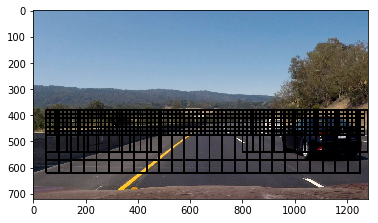

In [4]:
# Here is your draw_boxes function from the previous exercise
def draw_new_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for i in range(len(bboxes)):
        for bbox in bboxes[i]:
            # Draw a rectangle given bbox coordinates
            cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
   
def area_to_scale(area,a, b, minimum, maximum):
    if area>=maximum:
        return b 
    if area<=minimum:
        return a
    
    scaled = (((b-a)*(area+minimum))/(maximum-minimum))+a
    
    return scaled


all_bb = []



max_area= 135895
min_area = 1677
lower_scale_bound = 1
upper_scale_bound = 3

# NEAR RANGE     
    
ystart = 380
ystop = 620

xstart = 50
#xstart = 750

xstop = 1280
scale = 3
        

    
out_img, hog_image_ch1, hog_image_ch2, hog_image_ch3, bbox_list = find_cars(img,\
                                                                             ystart,\
                                                                             ystop,\
                                                                             xstart,\
                                                                             xstop,\
                                                                             scale,\
                                                                             scv_classyfier,\
                                                                             orient,\
                                                                             pix_per_cell,\
                                                                             cell_per_block,\
                                                                             visualization=True,\
                                                                             only_show_boxes=True  )

print("Scale 3", bbox_list[0])
A = pow((bbox_list[0][0][0]-bbox_list[0][1][0])/10,2) *  pow((bbox_list[0][0][1]-bbox_list[0][1][1])/10,2)
print("Area: ",A)

scale_from_area = area_to_scale(A,lower_scale_bound, upper_scale_bound, min_area, max_area)
print("Scale from area", scale_from_area)


all_bb.append(bbox_list)


################ NEAR RANGE FAR RIGHT     
    
ystart = 380
ystop = 550

#xstart = 50
xstart = 800

xstop = 1280
scale = 2.5
        

    
out_img, hog_image_ch1, hog_image_ch2, hog_image_ch3, bbox_list = find_cars(img,\
                                                                             ystart,\
                                                                             ystop,\
                                                                             xstart,\
                                                                             xstop,\
                                                                             scale,\
                                                                             scv_classyfier,\
                                                                             orient,\
                                                                             pix_per_cell,\
                                                                             cell_per_block,\
                                                                             visualization=True,\
                                                                             only_show_boxes=True  )


print("Scale 2.5", bbox_list[0])
A = pow((bbox_list[0][0][0]-bbox_list[0][1][0])/10,2) *  pow((bbox_list[0][0][1]-bbox_list[0][1][1])/10,2)
print("Area: ",A)

scale_from_area = area_to_scale(A,lower_scale_bound, upper_scale_bound, min_area, max_area)
print("Scale from area", scale_from_area)
all_bb.append(bbox_list)

######################## NEAR RANGE FAR LEFT 


# NEAR RANGE FAR LEFT     
    
ystart = 380
ystop = 550

xstart = 50
#xstart = 980

xstop = 500
scale = 2.5
        

    
out_img, hog_image_ch1, hog_image_ch2, hog_image_ch3, bbox_list = find_cars(img,\
                                                                             ystart,\
                                                                             ystop,\
                                                                             xstart,\
                                                                             xstop,\
                                                                             scale,\
                                                                             scv_classyfier,\
                                                                             orient,\
                                                                             pix_per_cell,\
                                                                             cell_per_block,\
                                                                             visualization=True,\
                                                                             only_show_boxes=True  )


print("Scale 2.5", bbox_list[0])
A = pow((bbox_list[0][0][0]-bbox_list[0][1][0])/10,2) *  pow((bbox_list[0][0][1]-bbox_list[0][1][1])/10,2)
print("Area: ",A)

scale_from_area = area_to_scale(A,lower_scale_bound, upper_scale_bound, min_area, max_area)
print("Scale from area", scale_from_area)
all_bb.append(bbox_list)



#################### FAR RANGE 

ystart = 380
ystop = 480

xstart = 50
#xstart = 750

xstop = 1280
scale = 1
        

    
out_img, hog_image_ch1, hog_image_ch2, hog_image_ch3, bbox_list = find_cars(img,\
                                                                             ystart,\
                                                                             ystop,\
                                                                             xstart,\
                                                                             xstop,\
                                                                             scale,\
                                                                             scv_classyfier,\
                                                                             orient,\
                                                                             pix_per_cell,\
                                                                             cell_per_block,\
                                                                             visualization=True,\
                                                                             only_show_boxes=True  )

print("Scale 1", bbox_list[0])
A = pow((bbox_list[0][0][0]-bbox_list[0][1][0])/10,2) *  pow((bbox_list[0][0][1]-bbox_list[0][1][1])/10,2)
print("Area: ",A)

scale_from_area = area_to_scale(A,lower_scale_bound, upper_scale_bound, min_area, max_area)
print("Scale from area", scale_from_area)

all_bb.append(bbox_list)









    
all_boxes_image = draw_new_boxes(np.copy(img), all_bb, color=(0, 0, 255), thick=6)

if test == True: 
    plt.imshow(all_boxes_image)
    plt.show()    
    
    
    #plt.imshow(hog_image_ch1)
    #plt.show()        
    #plt.imshow(hog_image_ch2)
    #plt.show()        
    #plt.imshow(hog_image_ch3)

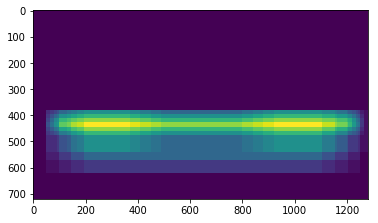

In [5]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for i in range(len(bbox_list)):
        for box in bbox_list[i]:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

if test == True: 
    # Test out the heatmap
    full_heatmap = np.zeros_like(img[:,:,0])
    full_heatmap = add_heat(full_heatmap, all_bb)                    
    plt.imshow(full_heatmap)


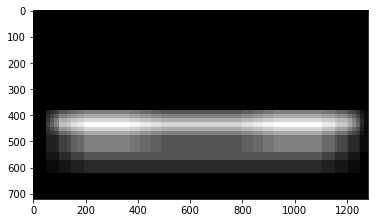

In [6]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    #print(np.max(heatmap[:]))
    heatmap[heatmap < threshold] = 0
    # Return thresholded map
    return heatmap


if test == True: 
    heatmap_threshold = 1
    binary_thresholded = apply_threshold(full_heatmap, heatmap_threshold)
    plt.imshow(binary_thresholded, cmap = 'gray')

5 cars found


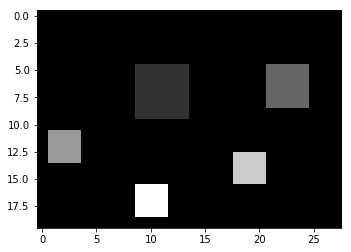

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 2 2 2 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 2 2 2 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 2 2 2 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 2 2 2 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 5 5 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

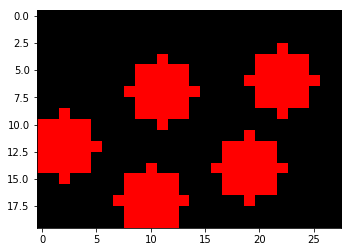

[((9, 5), (13, 9)), ((21, 5), (24, 8)), ((1, 11), (3, 13)), ((18, 13), (20, 15)), ((9, 16), (11, 18))]
5
5
Box center 0: (7.0, 11.0)
Coordiantes: ((9, 5), (13, 9))
Box center 1: (6.5, 22.5)
Coordiantes: ((21, 5), (24, 8))
Box center 2: (12.0, 2.0)
Coordiantes: ((1, 11), (3, 13))
Box center 3: (14.0, 19.0)
Coordiantes: ((18, 13), (20, 15))
Box center 4: (17.0, 10.0)
Coordiantes: ((9, 16), (11, 18))
Coordiantes x_min: 9 Coordiantes y_min: 16
Coordiantes x_max: 11 Coordiantes y_max: 18


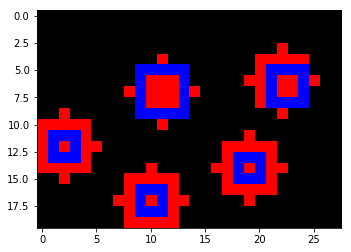

In [7]:
from scipy.ndimage.measurements import label
from scipy.ndimage.measurements import center_of_mass

def draw_centers(input_image, center_inputs, use_255=False):
    for i in range(len(center_inputs)):
        #print(center_inputs)
        if(np.isnan(center_inputs[i][0]) & np.isnan(center_inputs[i][1])):
            print("skip")
        else:
            print("center")
            # KEEP IN MIND - CV DRAWS (v,u) --> (y,x) --> AWWWRGHH! 
            # Color! 
            if use_255 == False:
                cv2.circle(input_image,(int(center_inputs[i][1]),int(center_inputs[i][0])), 10, (1,0,0), -1)
            else:
                cv2.circle(input_image,(int(center_inputs[i][1]),int(center_inputs[i][0])), 3, (255,0,0), -1)

    return input_image

def get_labeled_bboxes(labels):
    bbox = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        #print(np.min(nonzerox))
        #print(np.min(nonzeroy))
        #print(np.max(nonzerox))
        #print(np.max(nonzeroy))

        # Define a bounding box based on min/max x and y
        bbox.append(((np.min(nonzerox), np.min(nonzeroy)),(np.max(nonzerox),np.max(nonzeroy))))            
    return bbox

def draw_bboxes(input_image, bboxes, cofm, test=False):
    #print(bboxes)
    for i in range(len(bboxes)):
        #print(bboxes[i][0], ",", bboxes[i][1])
        #print(bboxes[i])
        #print(bboxes[i])
        if test==True:
            cv2.rectangle(input_image, bboxes[i][0], bboxes[i][1], (0,0,255),1)
        else:
            input_image = draw_centers(input_image, cofm, use_255=True)
            cv2.rectangle(input_image, bboxes[i][0], bboxes[i][1], (0,0,255),6)
    return input_image



######################## Testing center of mass scipy 


b = np.array(([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0],
              [0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0],
              [0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0],
              [0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0],
              [0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              [0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              [0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              [0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],))
labels = label(b)

if test == True: 
    print(labels[1], 'cars found')
    plt.imshow(labels[0], cmap='gray')
    plt.show()

print(labels[0])
    
    
# This acutually took me quite a while to realize how to use this to get all labels 
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.center_of_mass.html
# index : int or sequence of ints, optional
# Labels for which to calculate centers-of-mass. If not specified, all labels greater than zero are used. Only used with labels.
# list(range(1,labels[1]+1))
    
centers = center_of_mass(b, labels[0],list(range(1,labels[1]+1)))


#centers = center_of_mass(np.array(binary_thresholded))
print("centers",centers)

b_color = np.dstack((b, b, b))
b_color = b_color.astype(np.uint8)

center_image = draw_centers(b_color, centers, use_255=True)
plt.imshow(center_image)
plt.show()

bounding_boxes = get_labeled_bboxes(labels)
print (bounding_boxes) 
draw_img = draw_bboxes(np.copy(b_color), bounding_boxes, centers, test=True)

print(len(centers))
print(len(bounding_boxes))

print("Box center 0:", centers[0])
print("Coordiantes:", bounding_boxes[0])

print("Box center 1:", centers[1])
print("Coordiantes:", bounding_boxes[1])

print("Box center 2:", centers[2])
print("Coordiantes:", bounding_boxes[2])

print("Box center 3:", centers[3])
print("Coordiantes:", bounding_boxes[3])

print("Box center 4:", centers[4])
print("Coordiantes:", bounding_boxes[4])
print("Coordiantes x_min:", bounding_boxes[4][0][0] ,"Coordiantes y_min:", bounding_boxes[4][0][1])
print("Coordiantes x_max:", bounding_boxes[4][1][0] ,"Coordiantes y_max:", bounding_boxes[4][1][1])


# Display the image
plt.imshow(draw_img)
plt.show()
    
################################################################################

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
[(471.74540727902945, 656.00190641247832)]
center


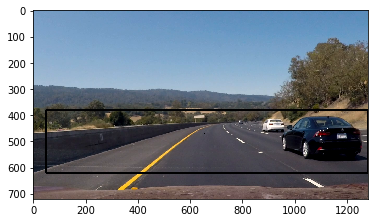

In [8]:
img = mpimg.imread('./30_second_car_overtake.png')
 
if test == True: 
    labels = label(binary_thresholded)
    print(labels)

    centers = center_of_mass(binary_thresholded, labels[0],list(range(1,labels[1]+1)))
    print(centers)
    
    # Draw bounding boxes on a copy of the image
    bounding_boxes = get_labeled_bboxes(labels)
    #print (bounding_boxes) 
    draw_img = draw_bboxes(np.copy(img), bounding_boxes, centers)
        
    # Display the image
    plt.imshow(draw_img)

In [9]:
import copy


class tracked_object():
    def __init__(self, _CENTER, _BB):
        # Camera name 
        # KEEP IN MIND center = (y,x)
        self.center = _CENTER 
        self.bb = _BB
        
class tracks():
    def __init__(self):
        self.objects = [] 
    
    def add_new_objects(self, _new_objects):
        self.objects = []
        self.objects = copy.deepcopy(_new_objects)
        
    def reset_objects(self):
        self.objects = []
    

tracked_objects = tracks()

In [13]:
print(img.shape[0])
print(img.shape[1])

720
1280


In [14]:
frame_counter = 0 
modulo_frame_skipper = 5


def process(input_image): 
    
    global frame_counter 
    global modulo_frame_skipper
    global tracked_objects 
    
    heatmap_threshold = 1
    offset_x = 100
    offset_y = 40

    
    all_bb = []
    
    ignore_left_side = False
    
    print("LENGTH TRACKED OBJECT LIST: ", len(tracked_objects.objects))
        
    if((frame_counter%modulo_frame_skipper == 0) | (len(tracked_objects.objects) == 0)):
       
        # Static search areas executed every n-th frame to detect new obstacles if obstacles are in list 
        # Also executed every frame as long no obstacles are present in the obstacle list 
                
        if ignore_left_side == True: 
            # NEAR RANGE FAR LEFT     

            ystart = 380
            ystop = 550

            xstart = 50

            xstop = 500
            scale = 2.5

            bbox_list1 = find_cars(input_image,\
                             ystart,\
                             ystop,\
                             xstart,\
                             xstop,\
                             scale,\
                             scv_classyfier,\
                             orient,\
                             pix_per_cell,\
                             cell_per_block,\
                             visualization=False,\
                             only_show_boxes=False  )

            print(bbox_list1)

            if len(bbox_list1) > 0:
                print("NEAR RANGE ", bbox_list1)
                all_bb.append(bbox_list1)  
        
        
        # NEAR RANGE 
        
        ystart = 380
        ystop = 620

        xstart = 50
        #start = 750

        xstop = 1280
        scale = 3
        
        
        
        bbox_list2 = find_cars(input_image,\
                     ystart,\
                     ystop,\
                     xstart,\
                     xstop,\
                     scale,\
                     scv_classyfier,\
                     orient,\
                     pix_per_cell,\
                     cell_per_block,\
                     visualization=False,\
                     only_show_boxes=False  )

        print(bbox_list2)
        
        if len(bbox_list2) > 0:
            print("NEAR RANGE ", bbox_list2)
            all_bb.append(bbox_list2)  
        

        
        # NEAR RANGE FAR RIGHT     

        ystart = 380
        ystop = 550

        xstart = 980

        xstop = 1280
        scale = 2.5
          
    
        bbox_list3 = find_cars(input_image,\
                 ystart,\
                 ystop,\
                 xstart,\
                 xstop,\
                 scale,\
                 scv_classyfier,\
                 orient,\
                 pix_per_cell,\
                 cell_per_block,\
                 visualization=False,\
                 only_show_boxes=False  )

        print(bbox_list3)
        
        if len(bbox_list3) > 0:
            print("NEAR RANGE FAR LEFT ", bbox_list3)
            all_bb.append(bbox_list3)  
        
    
        ystart = 380
        ystop = 480

        xstart = 50
        #start = 750

        xstop = 1280
        scale = 1
                
        
        # FAR RANGE 
        bbox_list4 = find_cars(input_image,\
                     ystart,\
                     ystop,\
                     xstart,\
                     xstop,\
                     scale,\
                     scv_classyfier,\
                     orient,\
                     pix_per_cell,\
                     cell_per_block,\
                     visualization=False,\
                     only_show_boxes=False  )

        print(bbox_list4)
        
        if len(bbox_list4) > 0:
            print("FAR RANGE ", bbox_list4)
            all_bb.append(bbox_list4)  
       
        old_centers = []
        old_bboxes = []
    
        # Refined search in areas where objects were detected in last iteration 
    
        for i in range(len(tracked_objects.objects)):
            old_centers.append(tracked_objects.objects[i].center)
            old_bboxes.append(tracked_objects.objects[i].bb)


            print(tracked_objects.objects[i].bb)

            print(tracked_objects.objects[i].bb[0])
            print(tracked_objects.objects[i].bb[1])

            print(tracked_objects.objects[i].bb[0][0])
            print(tracked_objects.objects[i].bb[0][1])

            print(tracked_objects.objects[i].bb[1][0])
            print(tracked_objects.objects[i].bb[1][1])
      
            xstart = tracked_objects.objects[i].bb[0][0] - offset_x
            xstop = tracked_objects.objects[i].bb[1][0] + offset_x

            ystart = tracked_objects.objects[i].bb[0][1] - offset_y
            ystop = tracked_objects.objects[i].bb[1][1] + offset_y 

            # Checking image boundaries 
            xstart = max(0,xstart)
            xstop = min(input_image.shape[1], xstop)
            ystart = max(0, ystart)
            ystop = min(input_image.shape[0], ystop)
            
            print("xstart: " , xstart, "xstop: ", xstop)
            print("ystart: " , ystart, "ystop: ", ystop)

            x_bb_size = tracked_objects.objects[i].bb[1][0]-tracked_objects.objects[i].bb[0][0] 
            y_bb_size = tracked_objects.objects[i].bb[1][1]-tracked_objects.objects[i].bb[0][1]

            print("x bb size: ", x_bb_size)
            print("y bb size: ", y_bb_size)

            A = pow((x_bb_size)/10,2) *\
                pow((y_bb_size)/10,2)
            print("Area: ",A)
            
            # Defining scale in relation to area of bounding box 
            # Searching of scale in a range of +/-0.2
            
            scale = area_to_scale(A,lower_scale_bound, upper_scale_bound, min_area, max_area)

            print("search scale: ", scale)

            search_area_bboxes = []

            # FAR RANGE 
            search_area_bboxes = find_cars(input_image,\
                         ystart,\
                         ystop,\
                         xstart,\
                         xstop,\
                         scale,\
                         scv_classyfier,\
                         orient,\
                         pix_per_cell,\
                         cell_per_block,\
                         visualization=False,\
                         only_show_boxes=False  )

            if len(search_area_bboxes) > 0:
                print("# new search boxes", len(search_area_bboxes))
                all_bb.append(search_area_bboxes)  
                       
            print("search scale: ",   scale + 0.2)

            search_area_bboxes = []

            # FAR RANGE 
            search_area_bboxes = find_cars(input_image,\
                         ystart,\
                         ystop,\
                         xstart,\
                         xstop,\
                           scale + 0.2,\
                         scv_classyfier,\
                         orient,\
                         pix_per_cell,\
                         cell_per_block,\
                         visualization=False,\
                         only_show_boxes=False  )

            if len(search_area_bboxes) > 0:
                print("# new search boxes", len(search_area_bboxes))
                all_bb.append(search_area_bboxes)  
         
             
            
            print("search scale: ", scale - 0.2)

            search_area_bboxes = []

            # FAR RANGE 
            search_area_bboxes = find_cars(input_image,\
                         ystart,\
                         ystop,\
                         xstart,\
                         xstop,\
                         scale - 0.2,\
                         scv_classyfier,\
                         orient,\
                         pix_per_cell,\
                         cell_per_block,\
                         visualization=False,\
                         only_show_boxes=False  )

            if len(search_area_bboxes) > 0:
                print("# new search boxes", len(search_area_bboxes))
                all_bb.append(search_area_bboxes)  
            
            heatmap_threshold = 2
        
        heatmap_threshold = 1
    
        # Use alle found bounding boxes to generate a heat map 
            
        if len(all_bb) > 0:
            full_heatmap = np.zeros_like(input_image[:,:,0])
            full_heatmap = add_heat(full_heatmap, all_bb)        
            
            binary_thresholded = apply_threshold(full_heatmap, heatmap_threshold)

            labels = []
            labels = label(binary_thresholded)
                               
            detection_boxes = []
            detection_boxes = get_labeled_bboxes(labels)
            
            new_centers = []
            # I do not now why there is always a second center of mass containted with NAN coordinates 
            #new_centers = center_of_mass(binary_thresholded, labels[0], [1,2])

            
            new_centers = center_of_mass(binary_thresholded, labels[0],list(range(1,labels[1]+1)))
            print(new_centers)
            
            new_objects = []
            
            for i in range(len(detection_boxes)):
                # (self, _CENTER, _BB):
                new_objects.append(tracked_object(new_centers[i] ,detection_boxes[i]))
            
            print(new_objects)
            
            if(len(tracked_objects.objects) == 0):
                print("No objects present, initializing with ", len(new_objects), " objects")
                tracked_objects.add_new_objects(new_objects)
            else:
                print("Updating Object list")
                tracked_objects.add_new_objects(new_objects)
            
            
            #plt.imshow(center_image)
            #plt.show()
                        
            #print (bounding_boxes) 
            res_image = draw_bboxes(np.copy(input_image), detection_boxes, new_centers)
            
            
            cv2.putText(res_image,'BB = %d'%(len(all_bb)),(55,55), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
        else:
            print("No new objects found in full search")
            res_image =  np.copy(input_image)    
    else:
        if(len(tracked_objects.objects) == 0):           
            print("No object copy image")
            res_image =  np.copy(input_image)
        else:
            print("Using last object positions")
            old_centers = []
            old_bboxes = []
            new_bboxes = []
            
            for i in range(len(tracked_objects.objects)):
                old_centers.append(tracked_objects.objects[i].center)
                old_bboxes.append(tracked_objects.objects[i].bb)
                
                
                print(tracked_objects.objects[i].bb)
                
                print(tracked_objects.objects[i].bb[0])
                print(tracked_objects.objects[i].bb[1])
                
                print(tracked_objects.objects[i].bb[0][0])
                print(tracked_objects.objects[i].bb[0][1])
                
                print(tracked_objects.objects[i].bb[1][0])
                print(tracked_objects.objects[i].bb[1][1])

                xstart = tracked_objects.objects[i].bb[0][0] - offset_x
            
                
                xstop = tracked_objects.objects[i].bb[1][0] + offset_x
                
                ystart = tracked_objects.objects[i].bb[0][1] - offset_y
                ystop = tracked_objects.objects[i].bb[1][1] + offset_y 
                
                # Checking image boundaries 
                xstart = max(0,xstart)
                xstop = min(input_image.shape[1], xstop)
                ystart = max(0, ystart)
                ystop = min(input_image.shape[0], ystop)
                
                print("xstart: " , xstart, "xstop: ", xstop)
                print("ystart: " , ystart, "ystop: ", ystop)
                
                x_bb_size = tracked_objects.objects[i].bb[1][0]-tracked_objects.objects[i].bb[0][0] 
                y_bb_size = tracked_objects.objects[i].bb[1][1]-tracked_objects.objects[i].bb[0][1]
                
                print("x bb size: ", x_bb_size)
                print("y bb size: ", y_bb_size)
                
                A = pow((x_bb_size)/10,2) *\
                    pow((y_bb_size)/10,2)
                print("Area: ",A)

                # Defining scale in relation to area of bounding box 
                # Searching of scale in a range of +/-0.2
                
                scale = area_to_scale(A,lower_scale_bound, upper_scale_bound, min_area, max_area)
                
                print("search scale: ", scale)

                search_area_bboxes = []

                # FAR RANGE 
                search_area_bboxes = find_cars(input_image,\
                             ystart,\
                             ystop,\
                             xstart,\
                             xstop,\
                             scale,\
                             scv_classyfier,\
                             orient,\
                             pix_per_cell,\
                             cell_per_block,\
                             visualization=False,\
                             only_show_boxes=False  )

                if len(search_area_bboxes) > 0:
                    print("# new search boxes", len(search_area_bboxes))
                    all_bb.append(search_area_bboxes)  

                print("search scale: ", scale)

                search_area_bboxes = []

                # FAR RANGE 
                search_area_bboxes = find_cars(input_image,\
                             ystart,\
                             ystop,\
                             xstart,\
                             xstop,\
                             scale + 0.2,\
                             scv_classyfier,\
                             orient,\
                             pix_per_cell,\
                             cell_per_block,\
                             visualization=False,\
                             only_show_boxes=False  )

                if len(search_area_bboxes) > 0:
                    print("# new search boxes", len(search_area_bboxes))
                    all_bb.append(search_area_bboxes)  
  

                print("search scale: ", scale - 0.2)

                search_area_bboxes = []

                # FAR RANGE 
                search_area_bboxes = find_cars(input_image,\
                             ystart,\
                             ystop,\
                             xstart,\
                             xstop,\
                             scale - 0.2,\
                             scv_classyfier,\
                             orient,\
                             pix_per_cell,\
                             cell_per_block,\
                             visualization=False,\
                             only_show_boxes=False  )

                if len(search_area_bboxes) > 0:
                    print("# new search boxes", len(search_area_bboxes))
                    all_bb.append(search_area_bboxes) 

        
        
            # Use alle found bounding boxes to generate a heat map 

            heatmap_threshold =3
            
            if len(all_bb) > 0:
                full_heatmap = np.zeros_like(input_image[:,:,0])
                full_heatmap = add_heat(full_heatmap, all_bb)        

                binary_thresholded = apply_threshold(full_heatmap, heatmap_threshold)

                labels = []
                labels = label(binary_thresholded)

                detection_boxes = []
                detection_boxes = get_labeled_bboxes(labels)

                new_centers = []
                # I do not now why there is always a second center of mass containted with NAN coordinates 
                #new_centers = center_of_mass(binary_thresholded, labels[0], [1,2])


                new_centers = center_of_mass(binary_thresholded, labels[0],list(range(1,labels[1]+1)))
                print(new_centers)

                new_objects = []

                for i in range(len(detection_boxes)):
                    # (self, _CENTER, _BB):
                    new_objects.append(tracked_object(new_centers[i] ,detection_boxes[i]))

                print(new_objects)

                if(len(tracked_objects.objects) == 0):
                    print("No objects present, initializing with ", len(new_objects), " objects")
                    tracked_objects.add_new_objects(new_objects)
                else:
                    print("Updating Object list")
                    tracked_objects.add_new_objects(new_objects)


                #plt.imshow(center_image)
                #plt.show()

                #print (bounding_boxes) 
                res_image = draw_bboxes(np.copy(input_image), detection_boxes, new_centers)


                cv2.putText(res_image,'BB = %d'%(len(all_bb)),(55,55), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
            else:
                print("No new objects found in full search, resetting tracked object list")
                tracked_objects.reset_objects()
                #res_image =  np.copy(input_image)   
                # ######################################## JUST FOR TEST   
                res_image = draw_bboxes(np.copy(input_image),\
                                                old_bboxes,\
                                                old_centers)        
                ############################################################################# #  


    frame_counter = frame_counter + 1
    cv2.putText(res_image,'Frame = %d'%(frame_counter),(55,35), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(res_image,'BB = %d'%(len(all_bb)),(55,55), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)

    
    return res_image

LENGTH TRACKED OBJECT LIST:  0
[]


/home/vuk/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


[]
[]
[]
No new objects found in full search


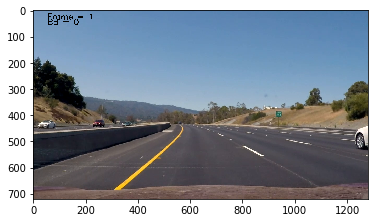

LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]
[]
No new objects found in full search


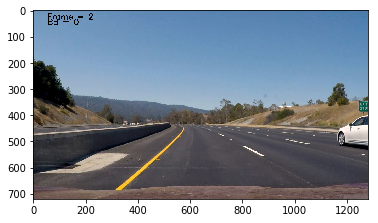

LENGTH TRACKED OBJECT LIST:  0
[]
[]
[((1100, 380), (1260, 540))]
NEAR RANGE FAR LEFT  [((1100, 380), (1260, 540))]
[]
[(459.5, 1179.5)]
No objects present, initializing with  1  objects
center


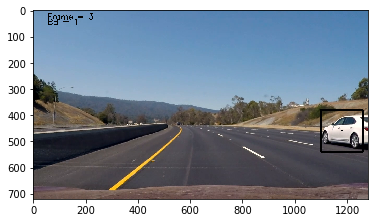

LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1100, 380), (1259, 539))
(1100, 380)
(1259, 539)
1100
380
1259
539
xstart:  1000 xstop:  1359
ystart:  340 ystop:  579
x bb size:  159
y bb size:  159
Area:  63912.8961
search scale:  1.97736363379
# new search boxes 3
search scale:  1.97736363379
# new search boxes 2
search scale:  1.77736363379
# new search boxes 4
[(446.735332401292, 1146.1033842742129)]
Updating Object list
center


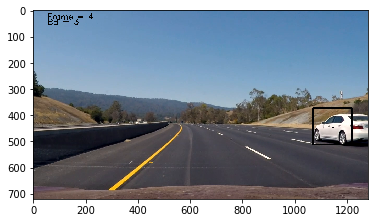

LENGTH TRACKED OBJECT LIST:  1
[]
[]
[((1060, 380), (1220, 540))]
NEAR RANGE FAR LEFT  [((1060, 380), (1220, 540))]
[]
((1069, 374), (1219, 512))
(1069, 374)
(1219, 512)
1069
374
1219
512
xstart:  969 xstop:  1319
ystart:  334 ystop:  552
x bb size:  150
y bb size:  138
Area:  42849.0
search scale:  1.66348775872
# new search boxes 8
search scale:  1.86348775872
# new search boxes 3
search scale:  1.46348775872
# new search boxes 5
[(451.10596572837153, 1150.4433643447837)]
Updating Object list
center


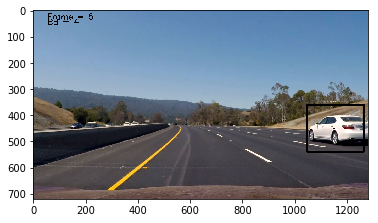

LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((1048, 360), (1265, 539))
(1048, 360)
(1265, 539)
1048
360
1265
539
xstart:  948 xstop:  1365
ystart:  320 ystop:  579
x bb size:  217
y bb size:  179
Area:  150877.8649
search scale:  3
search scale:  3
# new search boxes 2
search scale:  2.8
# new search boxes 2
[(450.52450726886167, 1135.2430040797565)]
Updating Object list
center


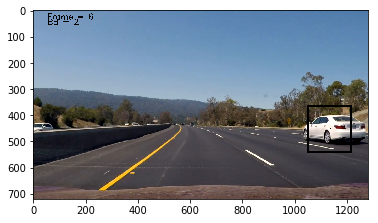

In [15]:
modulo_frame_skipper = 2

tracked_objects.reset_objects()


img = mpimg.imread('./05_first_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

img = mpimg.imread('./06_first_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

img = mpimg.imread('./07_first_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()


img = mpimg.imread('./08_first_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()


img = mpimg.imread('./09_first_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()


img = mpimg.imread('./10_first_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

LENGTH TRACKED OBJECT LIST:  1
[]


/home/vuk/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


[]
[]
[((914, 412), (978, 476))]
FAR RANGE  [((914, 412), (978, 476))]
((1050, 364), (1215, 542))
(1050, 364)
(1215, 542)
1050
364
1215
542
xstart:  950 xstop:  1315
ystart:  324 ystop:  582
x bb size:  165
y bb size:  178
Area:  86259.69
search scale:  2.31035613703
# new search boxes 1
search scale:  2.51035613703
# new search boxes 1
search scale:  2.11035613703
# new search boxes 1
[(435.1254566374227, 1019.2549978426579)]
Updating Object list
center


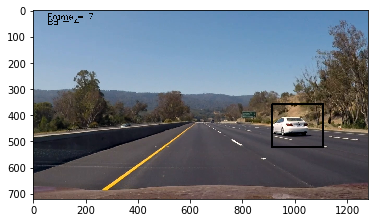

LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((914, 357), (1109, 523))
(914, 357)
(1109, 523)
914
357
1109
523
xstart:  814 xstop:  1209
ystart:  317 ystop:  563
x bb size:  195
y bb size:  166
Area:  104781.69
search scale:  2.58635488534
# new search boxes 1
search scale:  2.58635488534
# new search boxes 1
search scale:  2.38635488534
# new search boxes 3
[(440.26144597713488, 978.29373087864315)]
Updating Object list
center


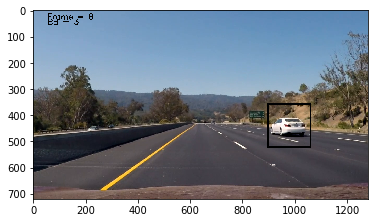

LENGTH TRACKED OBJECT LIST:  1
[]
[]
[]
[]
((896, 358), (1060, 522))
(896, 358)
(1060, 522)
896
358
1060
522
xstart:  796 xstop:  1160
ystart:  318 ystop:  562
x bb size:  164
y bb size:  164
Area:  72339.4816
search scale:  2.10292928817
# new search boxes 1
search scale:  2.30292928817
# new search boxes 1
search scale:  1.90292928817
# new search boxes 1
[(438.08683540567466, 972.99409659447292)]
Updating Object list
center


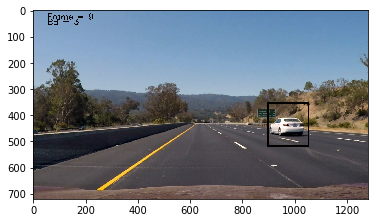

LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((896, 354), (1052, 518))
(896, 354)
(1052, 518)
896
354
1052
518
xstart:  796 xstop:  1152
ystart:  314 ystop:  558
x bb size:  156
y bb size:  164
Area:  65454.1056
search scale:  2.00032939844
# new search boxes 5
search scale:  2.00032939844
# new search boxes 4
search scale:  1.80032939844
# new search boxes 3
[(412.70290423225208, 959.4280214343263)]
Updating Object list
center


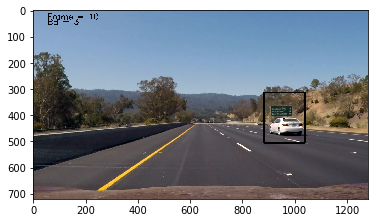

LENGTH TRACKED OBJECT LIST:  1
[]
[]
[]
[((898, 412), (962, 476))]
FAR RANGE  [((898, 412), (962, 476))]
((882, 314), (1040, 505))
(882, 314)
(1040, 505)
882
314
1040
505
xstart:  782 xstop:  1140
ystart:  274 ystop:  545
x bb size:  158
y bb size:  191
Area:  91071.1684
search scale:  2.38205260695
# new search boxes 5
search scale:  2.58205260695
# new search boxes 2
search scale:  2.18205260695
# new search boxes 5
[(405.62507989404111, 994.30503083078725)]
Updating Object list
center


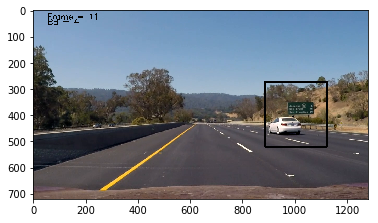

LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((886, 274), (1123, 520))
(886, 274)
(1123, 520)
886
274
1123
520
xstart:  786 xstop:  1223
ystart:  234 ystop:  560
x bb size:  237
y bb size:  246
Area:  339912.3204
search scale:  3
# new search boxes 1
search scale:  3
# new search boxes 1
search scale:  2.8
[]
[]
Updating Object list


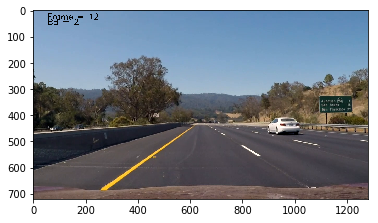

LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]
[((898, 412), (962, 476))]
FAR RANGE  [((898, 412), (962, 476))]
[(443.5, 929.5)]
No objects present, initializing with  1  objects
center


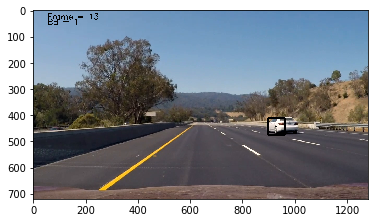

In [16]:
# modulo_frame_skipper = 2


img = mpimg.imread('./17_first_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

img = mpimg.imread('./17_5_first_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

img = mpimg.imread('./18_first_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

img = mpimg.imread('./18_5_first_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

img = mpimg.imread('./19_first_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

img = mpimg.imread('./19_5_first_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

img = mpimg.imread('./20_first_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

LENGTH TRACKED OBJECT LIST:  0
[]


/home/vuk/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


[]
[]
[((882, 396), (946, 460)), ((882, 412), (946, 476))]
FAR RANGE  [((882, 396), (946, 460)), ((882, 412), (946, 476))]
[(435.5, 913.5)]
No objects present, initializing with  1  objects
center


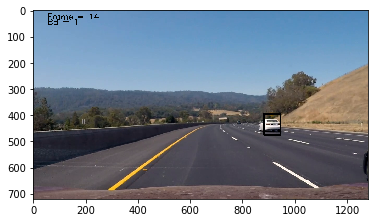

LENGTH TRACKED OBJECT LIST:  1
[]
[]
[]
[]
((882, 396), (945, 475))
(882, 396)
(945, 475)
882
396
945
475
xstart:  782 xstop:  1045
ystart:  356 ystop:  515
x bb size:  63
y bb size:  79
Area:  2477.0529
search scale:  1.06190008643
# new search boxes 3
search scale:  1.26190008643
# new search boxes 2
search scale:  0.861900086427
# new search boxes 6
[(439.5636805727537, 901.40756917396493)]
Updating Object list
center


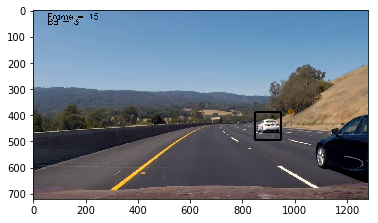

LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((849, 389), (946, 495))
(849, 389)
(946, 495)
849
389
946
495
xstart:  749 xstop:  1046
ystart:  349 ystop:  535
x bb size:  97
y bb size:  106
Area:  10571.9524
search scale:  1.18252324427
# new search boxes 4
search scale:  1.18252324427
# new search boxes 1
search scale:  0.982523244274
# new search boxes 3
[(435.33960411802167, 903.72139673105494)]
Updating Object list
center


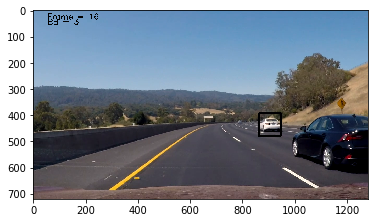

LENGTH TRACKED OBJECT LIST:  1
[]
[((962, 380), (1154, 572)), ((1058, 380), (1250, 572))]
NEAR RANGE  [((962, 380), (1154, 572)), ((1058, 380), (1250, 572))]
[]
[((898, 412), (962, 476))]
FAR RANGE  [((898, 412), (962, 476))]
((862, 393), (946, 479))
(862, 393)
(946, 479)
862
393
946
479
xstart:  762 xstop:  1046
ystart:  353 ystop:  519
x bb size:  84
y bb size:  86
Area:  5218.6176
search scale:  1.10275250115
# new search boxes 2
search scale:  1.30275250115
# new search boxes 2
search scale:  0.902752501155
# new search boxes 3
[(462.83777631827547, 1042.1910498520006)]
Updating Object list
center


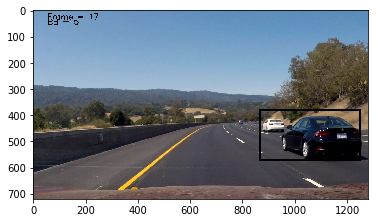

LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((866, 380), (1249, 571))
(866, 380)
(1249, 571)
866
380
1249
571
xstart:  766 xstop:  1349
ystart:  340 ystop:  611
x bb size:  383
y bb size:  191
Area:  535136.1409
search scale:  3
# new search boxes 4
search scale:  3
# new search boxes 4
search scale:  2.8
# new search boxes 4
[(476.97698776564755, 1068.3119050634514)]
Updating Object list
center


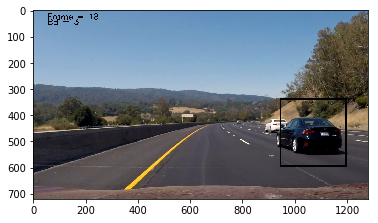

LENGTH TRACKED OBJECT LIST:  1
[]
[((914, 380), (1106, 572))]
NEAR RANGE  [((914, 380), (1106, 572))]
[]
[]
((945, 340), (1197, 594))
(945, 340)
(1197, 594)
945
340
1197
594
xstart:  845 xstop:  1297
ystart:  300 ystop:  634
x bb size:  252
y bb size:  254
Area:  409702.4064
search scale:  3
# new search boxes 3
search scale:  3.2
# new search boxes 3
search scale:  2.8
# new search boxes 3
[(465.40275549837554, 1019.865645026016)]
Updating Object list
center


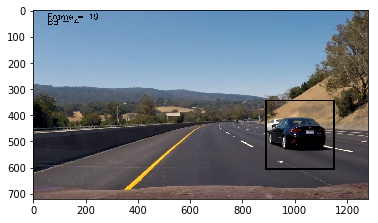

LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((889, 344), (1150, 605))
(889, 344)
(1150, 605)
889
344
1150
605
xstart:  789 xstop:  1250
ystart:  304 ystop:  645
x bb size:  261
y bb size:  261
Area:  464047.0641
search scale:  3
# new search boxes 3
search scale:  3
# new search boxes 2
search scale:  2.8
# new search boxes 4
[(458.91733115524016, 979.25637517654468)]
Updating Object list
center


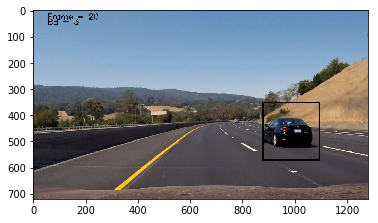

LENGTH TRACKED OBJECT LIST:  1
[]
[((866, 380), (1058, 572))]
NEAR RANGE  [((866, 380), (1058, 572))]
[]
[]
((878, 352), (1094, 571))
(878, 352)
(1094, 571)
878
352
1094
571
xstart:  778 xstop:  1194
ystart:  312 ystop:  611
x bb size:  216
y bb size:  219
Area:  223766.8416
search scale:  3
# new search boxes 2
search scale:  3.2
# new search boxes 2
search scale:  2.8
# new search boxes 2
[(458.6542771397331, 959.3750785169791)]
Updating Object list
center


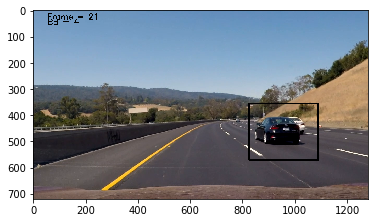

LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((826, 356), (1090, 571))
(826, 356)
(1090, 571)
826
356
1090
571
xstart:  726 xstop:  1190
ystart:  316 ystop:  611
x bb size:  264
y bb size:  215
Area:  322169.76
search scale:  3
# new search boxes 1
search scale:  3
# new search boxes 2
search scale:  2.8
# new search boxes 2
[(448.81172669134969, 916.90945136317737)]
Updating Object list
center


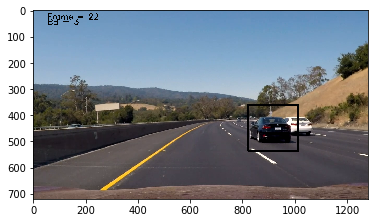

LENGTH TRACKED OBJECT LIST:  1
[]
[]
[]
[((978, 412), (1042, 476))]
FAR RANGE  [((978, 412), (1042, 476))]
((822, 360), (1013, 538))
(822, 360)
(1013, 538)
822
360
1013
538
xstart:  722 xstop:  1113
ystart:  320 ystop:  578
x bb size:  191
y bb size:  178
Area:  115586.4004
search scale:  2.74735729038
# new search boxes 2
search scale:  2.94735729038
# new search boxes 2
search scale:  2.54735729038
# new search boxes 4
[(446.64593702282201, 924.52316454129004)]
Updating Object list
center


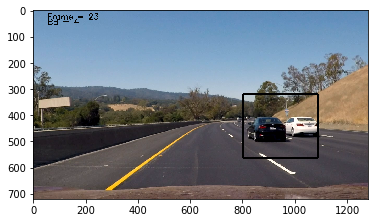

LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((803, 320), (1087, 563))
(803, 320)
(1087, 563)
803
320
1087
563
xstart:  703 xstop:  1187
ystart:  280 ystop:  603
x bb size:  284
y bb size:  243
Area:  476265.6144
search scale:  3
# new search boxes 2
search scale:  3
# new search boxes 2
search scale:  2.8
# new search boxes 3
[(433.96976742942974, 920.24605121790864)]
Updating Object list
center


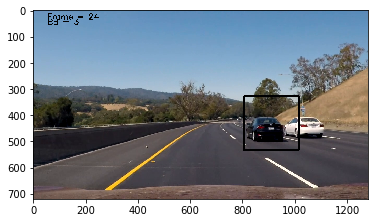

LENGTH TRACKED OBJECT LIST:  1
[]
[]
[((980, 380), (1140, 540))]
NEAR RANGE FAR LEFT  [((980, 380), (1140, 540))]
[((882, 412), (946, 476)), ((978, 412), (1042, 476)), ((1010, 412), (1074, 476))]
FAR RANGE  [((882, 412), (946, 476)), ((978, 412), (1042, 476)), ((1010, 412), (1074, 476))]
((805, 328), (1015, 534))
(805, 328)
(1015, 534)
805
328
1015
534
xstart:  705 xstop:  1115
ystart:  288 ystop:  574
x bb size:  210
y bb size:  206
Area:  187142.76
search scale:  3
# new search boxes 1
search scale:  3.2
# new search boxes 2
search scale:  2.8
# new search boxes 1
[(438.21971319563215, 916.19748454150772)]
Updating Object list
center


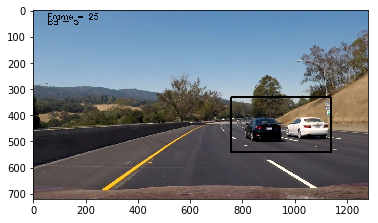

LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((756, 332), (1139, 542))
(756, 332)
(1139, 542)
756
332
1139
542
xstart:  656 xstop:  1239
ystart:  292 ystop:  582
x bb size:  383
y bb size:  210
Area:  646898.49
search scale:  3
# new search boxes 2
search scale:  3
# new search boxes 3
search scale:  2.8
# new search boxes 3
[(431.75536083596387, 956.13391593711606)]
Updating Object list
center


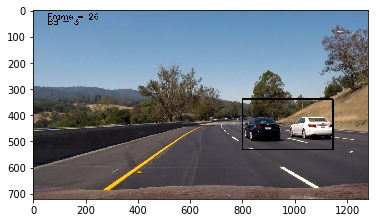

LENGTH TRACKED OBJECT LIST:  1
[]
[]
[((1020, 380), (1180, 540))]
NEAR RANGE FAR LEFT  [((1020, 380), (1180, 540))]
[((994, 412), (1058, 476)), ((1010, 412), (1074, 476)), ((1042, 412), (1106, 476))]
FAR RANGE  [((994, 412), (1058, 476)), ((1010, 412), (1074, 476)), ((1042, 412), (1106, 476))]
((800, 340), (1147, 531))
(800, 340)
(1147, 531)
800
340
1147
531
xstart:  700 xstop:  1247
ystart:  300 ystop:  571
x bb size:  347
y bb size:  191
Area:  439264.0729
search scale:  3
# new search boxes 3
search scale:  3.2
# new search boxes 2
search scale:  2.8
# new search boxes 5
[(442.16434857380517, 1007.9576236805242)]
Updating Object list
center


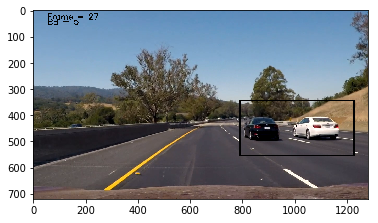

LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((789, 344), (1227, 554))
(789, 344)
(1227, 554)
789
344
1227
554
xstart:  689 xstop:  1327
ystart:  304 ystop:  594
x bb size:  438
y bb size:  210
Area:  846032.04
search scale:  3
# new search boxes 1
search scale:  3
# new search boxes 1
search scale:  2.8
# new search boxes 4
[(439.0, 1113.5), (440.5, 889.5)]
[<__main__.tracked_object object at 0x7f0e59acbb00>, <__main__.tracked_object object at 0x7f0e59acb400>]
Updating Object list
center
center
center
center


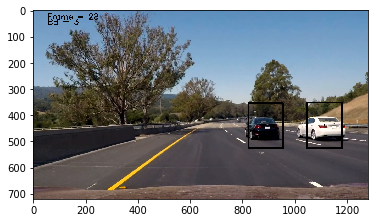

LENGTH TRACKED OBJECT LIST:  2
[]
[]
[((1020, 380), (1180, 540)), ((1060, 380), (1220, 540)), ((1100, 380), (1260, 540))]
NEAR RANGE FAR LEFT  [((1020, 380), (1180, 540)), ((1060, 380), (1220, 540)), ((1100, 380), (1260, 540))]
[((1042, 412), (1106, 476))]
FAR RANGE  [((1042, 412), (1106, 476))]
((1047, 352), (1180, 526))
(1047, 352)
(1180, 526)
1047
352
1180
526
xstart:  947 xstop:  1280
ystart:  312 ystop:  566
x bb size:  133
y bb size:  174
Area:  53555.2164
search scale:  1.82302249177
# new search boxes 6
search scale:  2.02302249177
# new search boxes 3
search scale:  1.62302249177
# new search boxes 5
((823, 355), (956, 526))
(823, 355)
(956, 526)
823
355
956
526
xstart:  723 xstop:  1056
ystart:  315 ystop:  566
x bb size:  133
y bb size:  171
Area:  51724.4049
search scale:  1.79574132978
# new search boxes 2
search scale:  1.99574132978
# new search boxes 3
search scale:  1.59574132978
# new search boxes 3
[(452.39169690098259, 1127.6975774754346), (455.22100368402607, 876.5

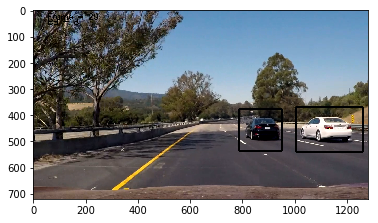

LENGTH TRACKED OBJECT LIST:  2
Using last object positions
((1005, 370), (1259, 539))
(1005, 370)
(1259, 539)
1005
370
1259
539
xstart:  905 xstop:  1359
ystart:  330 ystop:  579
x bb size:  254
y bb size:  169
Area:  184264.1476
search scale:  3
# new search boxes 1
search scale:  3
# new search boxes 1
search scale:  2.8
# new search boxes 3
((786, 378), (951, 536))
(786, 378)
(951, 536)
786
378
951
536
xstart:  686 xstop:  1051
ystart:  338 ystop:  576
x bb size:  165
y bb size:  158
Area:  67964.49
search scale:  2.03773696524
# new search boxes 2
search scale:  2.03773696524
# new search boxes 3
search scale:  1.83773696524
# new search boxes 3
[(435.64174213419318, 1143.7185909517773), (455.62105201460292, 883.1395820075694)]
[<__main__.tracked_object object at 0x7f0e5a5a5128>, <__main__.tracked_object object at 0x7f0e5a572128>]
Updating Object list
center
center
center
center


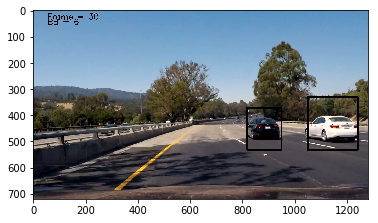

LENGTH TRACKED OBJECT LIST:  2
[]
[]
[((1060, 380), (1220, 540)), ((1100, 380), (1260, 540))]
NEAR RANGE FAR LEFT  [((1060, 380), (1220, 540)), ((1100, 380), (1260, 540))]
[]
((1049, 330), (1240, 533))
(1049, 330)
(1240, 533)
1049
330
1240
533
xstart:  949 xstop:  1340
ystart:  290 ystop:  573
x bb size:  191
y bb size:  203
Area:  150334.5529
search scale:  3
search scale:  3.2
# new search boxes 1
search scale:  2.8
# new search boxes 1
((816, 373), (949, 532))
(816, 373)
(949, 532)
816
373
949
532
xstart:  716 xstop:  1049
ystart:  333 ystop:  572
x bb size:  133
y bb size:  159
Area:  44719.5609
search scale:  1.69136123173
# new search boxes 3
search scale:  1.89136123173
# new search boxes 2
search scale:  1.49136123173
# new search boxes 6
[(444.46705431013078, 1160.3746045476025), (449.22228602310344, 887.69437782881846)]
[<__main__.tracked_object object at 0x7f0e59b33358>, <__main__.tracked_object object at 0x7f0e5a548a20>]
Updating Object list
center
center
center
center


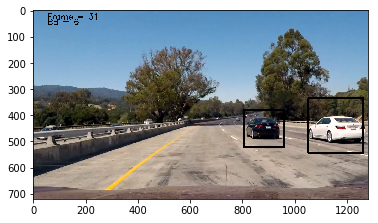

LENGTH TRACKED OBJECT LIST:  2
Using last object positions
((1051, 334), (1261, 544))
(1051, 334)
(1261, 544)
1051
334
1261
544
xstart:  951 xstop:  1361
ystart:  294 ystop:  584
x bb size:  210
y bb size:  210
Area:  194481.0
search scale:  3
search scale:  3
search scale:  2.8
# new search boxes 1
((806, 380), (958, 522))
(806, 380)
(958, 522)
806
380
958
522
xstart:  706 xstop:  1058
ystart:  340 ystop:  562
x bb size:  152
y bb size:  142
Area:  46586.9056
search scale:  1.71918677972
# new search boxes 4
search scale:  1.71918677972
# new search boxes 3
search scale:  1.51918677972
# new search boxes 4
[(440.79419126251463, 884.00741125991419)]
Updating Object list
center


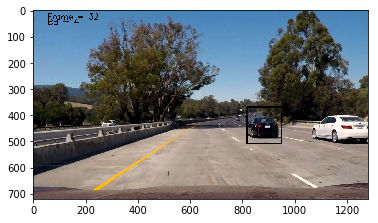

LENGTH TRACKED OBJECT LIST:  1
[]
[]
[]
[((834, 412), (898, 476)), ((866, 412), (930, 476))]
FAR RANGE  [((834, 412), (898, 476)), ((866, 412), (930, 476))]
((816, 370), (949, 508))
(816, 370)
(949, 508)
816
370
949
508
xstart:  716 xstop:  1049
ystart:  330 ystop:  548
x bb size:  133
y bb size:  138
Area:  33686.9316
search scale:  1.5269625773
# new search boxes 4
search scale:  1.7269625773
# new search boxes 3
search scale:  1.3269625773
# new search boxes 4
[(445.95469950703205, 880.31764716543421)]
Updating Object list
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((798, 378), (958, 521))
(798, 378)
(958, 521)
798
378
958
521
xstart:  698 xstop:  1058
ystart:  338 ystop:  561
x bb size:  160
y bb size:  143
Area:  52349.44
search scale:  1.80505505968
# new search boxes 2
search scale:  1.80505505968
# new search boxes 3
search scale:  1.60505505968
# new search boxes 5
[(449.80780189607833, 883.47079901224333)]
Updating Object list
center


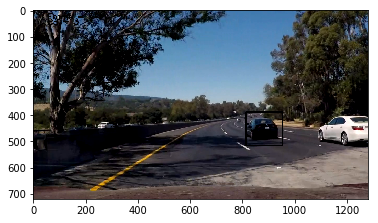

LENGTH TRACKED OBJECT LIST:  1
[]
[]
[((1100, 380), (1260, 540))]
NEAR RANGE FAR LEFT  [((1100, 380), (1260, 540))]
[((834, 412), (898, 476))]
FAR RANGE  [((834, 412), (898, 476))]
((813, 389), (953, 516))
(813, 389)
(953, 516)
813
389
953
516
xstart:  713 xstop:  1053
ystart:  349 ystop:  556
x bb size:  140
y bb size:  127
Area:  31612.84
search scale:  1.49605626667
# new search boxes 4
search scale:  1.69605626667
# new search boxes 2
search scale:  1.29605626667
# new search boxes 5
[(439.37245738285429, 876.83103434077248), (459.5, 1179.5)]
[<__main__.tracked_object object at 0x7f0e5a354908>, <__main__.tracked_object object at 0x7f0e5a4987b8>]
Updating Object list
center
center
center
center


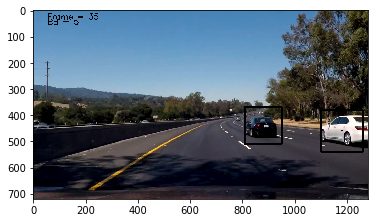

LENGTH TRACKED OBJECT LIST:  2
Using last object positions
((808, 369), (950, 510))
(808, 369)
(950, 510)
808
369
950
510
xstart:  708 xstop:  1050
ystart:  329 ystop:  550
x bb size:  142
y bb size:  141
Area:  40088.0484
search scale:  1.62234645726
# new search boxes 4
search scale:  1.62234645726
# new search boxes 2
search scale:  1.42234645726
# new search boxes 5
((1100, 380), (1259, 539))
(1100, 380)
(1259, 539)
1100
380
1259
539
xstart:  1000 xstop:  1359
ystart:  340 ystop:  579
x bb size:  159
y bb size:  159
Area:  63912.8961
search scale:  1.97736363379
# new search boxes 3
search scale:  1.97736363379
# new search boxes 1
search scale:  1.77736363379
# new search boxes 3
[(446.6118404309467, 1179.1950606549033), (445.4370580586376, 874.38920263100442)]
[<__main__.tracked_object object at 0x7f0e5a2e7a20>, <__main__.tracked_object object at 0x7f0e5a2e7780>]
Updating Object list
center
center
center
center


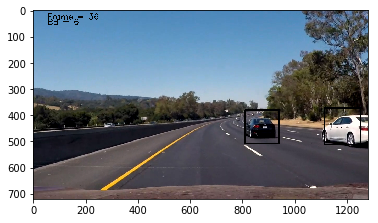

LENGTH TRACKED OBJECT LIST:  2
[]
[]
[((1100, 380), (1260, 540))]
NEAR RANGE FAR LEFT  [((1100, 380), (1260, 540))]
[((834, 412), (898, 476)), ((850, 396), (914, 460))]
FAR RANGE  [((834, 412), (898, 476)), ((850, 396), (914, 460))]
((1113, 374), (1251, 512))
(1113, 374)
(1251, 512)
1113
374
1251
512
xstart:  1013 xstop:  1351
ystart:  334 ystop:  552
x bb size:  138
y bb size:  138
Area:  36267.3936
search scale:  1.56541437959
# new search boxes 4
search scale:  1.76541437959
# new search boxes 5
search scale:  1.36541437959
# new search boxes 6
((811, 380), (939, 508))
(811, 380)
(939, 508)
811
380
939
508
xstart:  711 xstop:  1039
ystart:  340 ystop:  548
x bb size:  128
y bb size:  128
Area:  26843.5456
search scale:  1.42498838606
# new search boxes 6
search scale:  1.62498838606
# new search boxes 3
search scale:  1.22498838606
# new search boxes 8
[(439.09198783034753, 869.78264451462314), (447.61944121473056, 1185.4101269757216)]
[<__main__.tracked_object object at 0x7f0e591d4

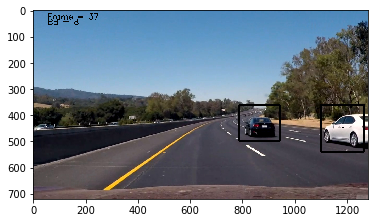

LENGTH TRACKED OBJECT LIST:  2
Using last object positions
((788, 362), (942, 498))
(788, 362)
(942, 498)
788
362
942
498
xstart:  688 xstop:  1042
ystart:  322 ystop:  538
x bb size:  154
y bb size:  136
Area:  43865.1136
search scale:  1.67862900058
# new search boxes 2
search scale:  1.67862900058
# new search boxes 1
search scale:  1.47862900058
# new search boxes 4
((1100, 362), (1265, 539))
(1100, 362)
(1265, 539)
1100
362
1265
539
xstart:  1000 xstop:  1365
ystart:  322 ystop:  579
x bb size:  165
y bb size:  177
Area:  85293.2025
search scale:  2.29595438019
# new search boxes 1
search scale:  2.29595438019
# new search boxes 1
search scale:  2.09595438019
# new search boxes 1
[(440.5234536003199, 873.26509489095997), (457.0, 1194.5)]
[<__main__.tracked_object object at 0x7f0e9d9f5390>, <__main__.tracked_object object at 0x7f0e591ee9b0>]
Updating Object list
center
center
center
center


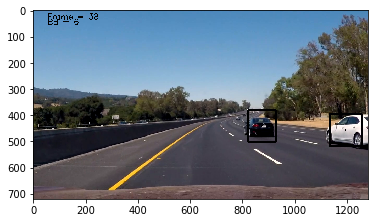

In [17]:
modulo_frame_skipper = 2


tracked_objects.reset_objects()


img = mpimg.imread('./27_second_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

img = mpimg.imread('./28_second_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

img = mpimg.imread('./29_second_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

img = mpimg.imread('./30_second_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

img = mpimg.imread('./31_second_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

img = mpimg.imread('./32_second_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

img = mpimg.imread('./33_second_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

img = mpimg.imread('./34_second_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

img = mpimg.imread('./35_second_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

img = mpimg.imread('./36_second_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

img = mpimg.imread('./36_5_second_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

img = mpimg.imread('./37_second_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

img = mpimg.imread('./37_5_second_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

img = mpimg.imread('./38_second_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

img = mpimg.imread('./38_5_second_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

img = mpimg.imread('./39_second_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

img = mpimg.imread('./39_5_second_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

img = mpimg.imread('./40_second_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

img = mpimg.imread('./40_5_second_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

img = mpimg.imread('./41_second_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show

img = mpimg.imread('./41_5_second_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

img = mpimg.imread('./42_second_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

img = mpimg.imread('./42_5_second_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

img = mpimg.imread('./43_second_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

img = mpimg.imread('./43_5_second_car_overtake.png')
result_image = process(img)
plt.imshow(result_image)
plt.show()

In [18]:

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from math import *


modulo_frame_skipper = 2

tracked_objects.reset_objects()


white_output = 'output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds


# First curve 

# first car drive by 
#clip1 = VideoFileClip("project_video.mp4").subclip(6,10)


# Second car drive by 
#clip1 = VideoFileClip("project_video.mp4").subclip(26,31)


# first to second 
#clip1 = VideoFileClip("project_video.mp4").subclip(6,31)


# Larger Part of the video 
#clip1 = VideoFileClip("project_video.mp4").subclip(29,50)

# Whole video 
clip1 = VideoFileClip("project_video.mp4")

#VideoFileClip("project_video.mp4").save_frame("05_first_car_overtake.png", t=5, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("06_first_car_overtake.png", t=6, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("07_first_car_overtake.png", t=7, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("08_first_car_overtake.png", t=8, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("09_first_car_overtake.png", t=9, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("10_first_car_overtake.png", t=10, withmask=True)




#VideoFileClip("project_video.mp4").save_frame("17_first_car_overtake.png", t=17, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("17_5_first_car_overtake.png", t=17.5, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("18_first_car_overtake.png", t=18, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("18_5_first_car_overtake.png", t=18.5, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("19_first_car_overtake.png", t=19, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("19_5_first_car_overtake.png", t=19.5, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("20_first_car_overtake.png", t=20, withmask=True)




#VideoFileClip("project_video.mp4").save_frame("27_second_car_overtake.png", t=27, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("28_second_car_overtake.png", t=28, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("29_second_car_overtake.png", t=29, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("30_second_car_overtake.png", t=30, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("31_second_car_overtake.png", t=31, withmask=True)

#VideoFileClip("project_video.mp4").save_frame("31_second_car_overtake.png", t=31, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("32_second_car_overtake.png", t=32, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("33_second_car_overtake.png", t=33, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("34_second_car_overtake.png", t=34, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("35_second_car_overtake.png", t=35, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("36_second_car_overtake.png", t=36, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("36_5_second_car_overtake.png", t=36.5, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("37_second_car_overtake.png", t=37, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("37_5_second_car_overtake.png", t=37.5, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("38_second_car_overtake.png", t=38, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("38_5_second_car_overtake.png", t=38.5, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("39_second_car_overtake.png", t=39, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("39_5_second_car_overtake.png", t=39.5, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("40_second_car_overtake.png", t=40, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("40_5_second_car_overtake.png", t=40.5, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("41_second_car_overtake.png", t=41, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("41_5_second_car_overtake.png", t=41.5, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("42_second_car_overtake.png", t=42, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("42_5_second_car_overtake.png", t=42.5, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("43_second_car_overtake.png", t=43, withmask=True)
#VideoFileClip("project_video.mp4").save_frame("43_5_second_car_overtake.png", t=43.5, withmask=True)





white_clip = clip1.fl_image(process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]
[]
No new objects found in full search
[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  0%|          | 1/1261 [00:03<1:05:56,  3.14s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  0%|          | 2/1261 [00:06<1:06:41,  3.18s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  0%|          | 3/1261 [00:09<1:06:17,  3.16s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  0%|          | 4/1261 [00:12<1:05:58,  3.15s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  0%|          | 5/1261 [00:15<1:06:05,  3.16s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  0%|          | 6/1261 [00:18<1:05:31,  3.13s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  1%|          | 7/1261 [00:21<1:05:14,  3.12s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  1%|          | 8/1261 [00:25<1:06:25,  3.18s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  1%|          | 9/1261 [00:28<1:06:13,  3.17s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  1%|          | 10/1261 [00:31<1:05:39,  3.15s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  1%|          | 11/1261 [00:34<1:05:07,  3.13s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  1%|          | 12/1261 [00:37<1:04:37,  3.10s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  1%|          | 13/1261 [00:40<1:04:21,  3.09s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  1%|          | 14/1261 [00:43<1:04:03,  3.08s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  1%|          | 15/1261 [00:46<1:03:48,  3.07s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  1%|▏         | 16/1261 [00:49<1:03:46,  3.07s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  1%|▏         | 17/1261 [00:53<1:03:47,  3.08s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  1%|▏         | 18/1261 [00:56<1:03:38,  3.07s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  2%|▏         | 19/1261 [00:59<1:03:26,  3.06s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  2%|▏         | 20/1261 [01:02<1:04:03,  3.10s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  2%|▏         | 21/1261 [01:05<1:04:00,  3.10s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  2%|▏         | 22/1261 [01:08<1:03:44,  3.09s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  2%|▏         | 23/1261 [01:11<1:03:36,  3.08s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  2%|▏         | 24/1261 [01:14<1:04:49,  3.14s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  2%|▏         | 25/1261 [01:17<1:04:54,  3.15s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  2%|▏         | 26/1261 [01:21<1:04:17,  3.12s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  2%|▏         | 27/1261 [01:24<1:04:23,  3.13s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  2%|▏         | 28/1261 [01:27<1:04:16,  3.13s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  2%|▏         | 29/1261 [01:30<1:03:52,  3.11s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  2%|▏         | 30/1261 [01:33<1:03:51,  3.11s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  2%|▏         | 31/1261 [01:36<1:05:26,  3.19s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  3%|▎         | 32/1261 [01:40<1:05:06,  3.18s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  3%|▎         | 33/1261 [01:43<1:04:23,  3.15s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  3%|▎         | 34/1261 [01:46<1:04:21,  3.15s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  3%|▎         | 35/1261 [01:49<1:03:52,  3.13s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  3%|▎         | 36/1261 [01:52<1:03:36,  3.12s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  3%|▎         | 37/1261 [01:55<1:04:18,  3.15s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  3%|▎         | 38/1261 [01:58<1:03:44,  3.13s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  3%|▎         | 39/1261 [02:01<1:03:45,  3.13s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  3%|▎         | 40/1261 [02:05<1:07:12,  3.30s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  3%|▎         | 41/1261 [02:08<1:06:09,  3.25s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  3%|▎         | 42/1261 [02:11<1:04:59,  3.20s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  3%|▎         | 43/1261 [02:14<1:04:31,  3.18s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  3%|▎         | 44/1261 [02:18<1:04:36,  3.18s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  4%|▎         | 45/1261 [02:21<1:04:27,  3.18s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  4%|▎         | 46/1261 [02:24<1:04:17,  3.17s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  4%|▎         | 47/1261 [02:27<1:04:00,  3.16s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  4%|▍         | 48/1261 [02:30<1:03:57,  3.16s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  4%|▍         | 49/1261 [02:33<1:03:57,  3.17s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  4%|▍         | 50/1261 [02:37<1:03:51,  3.16s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  4%|▍         | 51/1261 [02:40<1:03:47,  3.16s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  4%|▍         | 52/1261 [02:43<1:04:05,  3.18s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  4%|▍         | 53/1261 [02:46<1:04:07,  3.18s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  4%|▍         | 54/1261 [02:49<1:04:08,  3.19s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  4%|▍         | 55/1261 [02:53<1:04:12,  3.19s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  4%|▍         | 56/1261 [02:56<1:04:56,  3.23s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  5%|▍         | 57/1261 [02:59<1:04:58,  3.24s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  5%|▍         | 58/1261 [03:02<1:05:12,  3.25s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  5%|▍         | 59/1261 [03:06<1:06:23,  3.31s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  5%|▍         | 60/1261 [03:09<1:06:40,  3.33s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  5%|▍         | 61/1261 [03:13<1:06:29,  3.32s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  5%|▍         | 62/1261 [03:16<1:06:06,  3.31s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  5%|▍         | 63/1261 [03:19<1:05:37,  3.29s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  5%|▌         | 64/1261 [03:22<1:05:05,  3.26s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  5%|▌         | 65/1261 [03:25<1:04:38,  3.24s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  5%|▌         | 66/1261 [03:29<1:04:00,  3.21s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  5%|▌         | 67/1261 [03:32<1:03:38,  3.20s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  5%|▌         | 68/1261 [03:35<1:03:10,  3.18s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  5%|▌         | 69/1261 [03:38<1:02:47,  3.16s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  6%|▌         | 70/1261 [03:41<1:03:00,  3.17s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  6%|▌         | 71/1261 [03:44<1:03:31,  3.20s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  6%|▌         | 72/1261 [03:48<1:03:35,  3.21s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  6%|▌         | 73/1261 [03:51<1:03:12,  3.19s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  6%|▌         | 74/1261 [03:54<1:02:46,  3.17s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  6%|▌         | 75/1261 [03:57<1:02:29,  3.16s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  6%|▌         | 76/1261 [04:00<1:02:36,  3.17s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  6%|▌         | 77/1261 [04:03<1:02:28,  3.17s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  6%|▌         | 78/1261 [04:07<1:02:30,  3.17s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  6%|▋         | 79/1261 [04:10<1:02:31,  3.17s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  6%|▋         | 80/1261 [04:13<1:02:37,  3.18s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  6%|▋         | 81/1261 [04:16<1:02:37,  3.18s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  7%|▋         | 82/1261 [04:19<1:02:44,  3.19s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  7%|▋         | 83/1261 [04:23<1:02:41,  3.19s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  7%|▋         | 84/1261 [04:26<1:02:36,  3.19s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  7%|▋         | 85/1261 [04:29<1:02:37,  3.20s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  7%|▋         | 86/1261 [04:32<1:02:45,  3.20s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  7%|▋         | 87/1261 [04:36<1:03:11,  3.23s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  7%|▋         | 88/1261 [04:39<1:03:22,  3.24s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  7%|▋         | 89/1261 [04:42<1:03:06,  3.23s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  7%|▋         | 90/1261 [04:45<1:02:47,  3.22s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  7%|▋         | 91/1261 [04:48<1:02:32,  3.21s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  7%|▋         | 92/1261 [04:52<1:02:18,  3.20s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  7%|▋         | 93/1261 [04:55<1:02:13,  3.20s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  7%|▋         | 94/1261 [04:58<1:02:13,  3.20s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  8%|▊         | 95/1261 [05:01<1:02:47,  3.23s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  8%|▊         | 96/1261 [05:04<1:02:33,  3.22s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  8%|▊         | 97/1261 [05:08<1:02:17,  3.21s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  8%|▊         | 98/1261 [05:11<1:02:02,  3.20s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  8%|▊         | 99/1261 [05:14<1:01:53,  3.20s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  8%|▊         | 100/1261 [05:17<1:01:54,  3.20s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  8%|▊         | 101/1261 [05:21<1:02:20,  3.22s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  8%|▊         | 102/1261 [05:24<1:02:06,  3.21s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  8%|▊         | 103/1261 [05:27<1:02:39,  3.25s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  8%|▊         | 104/1261 [05:30<1:02:53,  3.26s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  8%|▊         | 105/1261 [05:34<1:02:20,  3.24s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  8%|▊         | 106/1261 [05:37<1:01:54,  3.22s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  8%|▊         | 107/1261 [05:40<1:01:40,  3.21s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  9%|▊         | 108/1261 [05:43<1:01:31,  3.20s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  9%|▊         | 109/1261 [05:46<1:01:17,  3.19s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  9%|▊         | 110/1261 [05:49<1:01:09,  3.19s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  9%|▉         | 111/1261 [05:53<1:00:41,  3.17s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  9%|▉         | 112/1261 [05:56<1:00:27,  3.16s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  9%|▉         | 113/1261 [05:59<1:00:19,  3.15s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  9%|▉         | 114/1261 [06:02<1:00:08,  3.15s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  9%|▉         | 115/1261 [06:05<1:00:09,  3.15s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  9%|▉         | 116/1261 [06:08<59:58,  3.14s/it]  

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  9%|▉         | 117/1261 [06:11<59:47,  3.14s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  9%|▉         | 118/1261 [06:14<59:40,  3.13s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


  9%|▉         | 119/1261 [06:18<1:00:39,  3.19s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


 10%|▉         | 120/1261 [06:21<1:01:03,  3.21s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


 10%|▉         | 121/1261 [06:24<1:00:41,  3.19s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


 10%|▉         | 122/1261 [06:27<1:00:38,  3.19s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


 10%|▉         | 123/1261 [06:31<1:00:34,  3.19s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


 10%|▉         | 124/1261 [06:34<1:00:30,  3.19s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


 10%|▉         | 125/1261 [06:37<1:00:24,  3.19s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


 10%|▉         | 126/1261 [06:40<1:00:05,  3.18s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


 10%|█         | 127/1261 [06:43<59:49,  3.17s/it]  

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


 10%|█         | 128/1261 [06:46<59:37,  3.16s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


 10%|█         | 129/1261 [06:50<59:24,  3.15s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


 10%|█         | 130/1261 [06:53<59:15,  3.14s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


 10%|█         | 131/1261 [06:56<59:12,  3.14s/it]

[]
No new objects found in full search
LENGTH TRACKED OBJECT LIST:  0
[]
[]
[]


 10%|█         | 132/1261 [06:59<59:27,  3.16s/it]

[((146, 396), (210, 460))]
FAR RANGE  [((146, 396), (210, 460))]
[(427.5, 177.5)]
No objects present, initializing with  1  objects
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((146, 396), (209, 459))
(146, 396)
(209, 459)
146
396
209
459
xstart:  46 xstop:  309
ystart:  356 ystop:  499
x bb size:  63
y bb size:  63
Area:  1575.2960999999998
search scale:  1
# new search boxes 1
search scale:  1
# new search boxes 1
search scale:  0.8


 11%|█         | 133/1261 [07:02<57:47,  3.07s/it]

# new search boxes 2
[(432.0, 155.151376146789)]
Updating Object list
center
LENGTH TRACKED OBJECT LIST:  1
[]
[]
[]
[]
((126, 407), (185, 457))
(126, 407)
(185, 457)
126
407
185
457
xstart:  26 xstop:  285
ystart:  367 ystop:  497
x bb size:  59
y bb size:  50
Area:  870.25
search scale:  1
# new search boxes 1
search scale:  1.2
# new search boxes 1
search scale:  0.8


 11%|█         | 134/1261 [07:07<1:12:16,  3.85s/it]

# new search boxes 1
[(435.95269782730696, 138.94748657099333)]
Updating Object list
center
LENGTH TRACKED OBJECT LIST:  1
Using last object positions
((102, 399), (177, 480))
(102, 399)
(177, 480)
102
399
177
480
xstart:  2 xstop:  277
ystart:  359 ystop:  520
x bb size:  75
y bb size:  81
Area:  3690.5625
search scale:  1.0799827519408722
# new search boxes 2
search scale:  1.0799827519408722
# new search boxes 1
search scale:  0.8799827519408723


 11%|█         | 135/1261 [07:10<1:06:31,  3.55s/it]

# new search boxes 2
[(439.81720801658605, 121.08753743377102)]
Updating Object list
center
LENGTH TRACKED OBJECT LIST:  1
[]
[]
[]
[]
((88, 410), (156, 470))
(88, 410)
(156, 470)
88
410
156
470
xstart:  -12 xstop:  256
ystart:  370 ystop:  510
x bb size:  68
y bb size:  60
Area:  1664.6399999999999
search scale:  1


TypeError: 'NoneType' object is not subscriptable